## Basic EPS prediction model - RandomForestClassifier and GradientBoosting Classier Models
- Trained on the full compustat annual fundamentals database
- Gradient Boosting achieved a 64.9% accuracy score 
- Strongest predictors of next year EPS expectations were lagged EPS and revenue growth

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

import pandas_datareader.data as web
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)

os.chdir(r"C:\Users\holde\OneDrive\Coding Projects")

In [ ]:
df = pd.read_csv("EPSpred.csv")
df = df.sort_values(["gvkey", "fyear"])

df["roa"]   = df["ni"] / df["at"]
df["rg"]    = df.groupby("gvkey")["sale"].pct_change()
df["bl"]    = (df["dltt"] + df["dlc"]) / df["at"]
df["om"]    = df["oiadp"] / df["sale"]
df["ac"]    = (df["ni"] - df["oancf"]) / df["at"]
df["capxa"] = df["capx"] / df["at"]

df["epsl"]  = df.groupby("gvkey")["epspx"].shift(1) #lagged
df["epsf"]  = df.groupby("gvkey")["epspx"].shift(-1) #next year eps target
df["epsUP"] = (df["epsf"] > df["epsl"]).astype(int)  #set as 0 or 1 so we can use classifier models where we are predicting binary targets.

df = df.replace([np.inf, -np.inf], np.nan)

predictor_columns = ["roa", "rg", "bl", "om", "ac", "capxa", "epsl"]
predictors = df[predictor_columns]
targetEPS = df["epsUP"]

alldata = pd.concat([predictors, targetEPS], axis=1).dropna()

for var in alldata:
    lo = df[var].quantile(.01)
    hi = df[var].quantile(.99)
    df[var] = df[var].clip(lower=lo, upper=hi)


In [4]:
# we are predicting "y" from "X"
X = alldata[predictor_columns]
y = alldata["epsUP"]

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, random_state=123)

len(X_train), len(y_train), len(X_test), len(y_test)

(36260, 36260, 12087, 12087)

In [5]:
model = RandomForestClassifier(n_estimators = 200, random_state=123)
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

accuracy_score(y_test, yhat_test) #accuracy score is just 1-mean squared error

0.6455696202531646

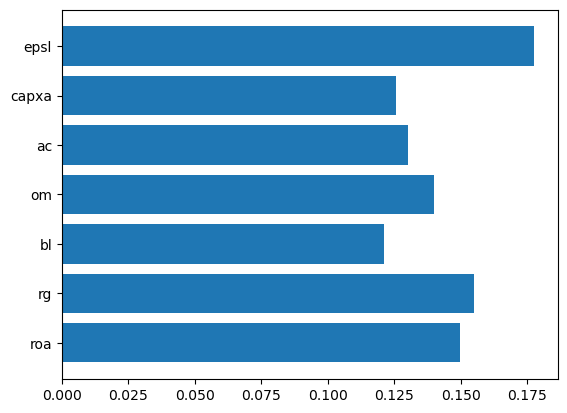

In [6]:
#feature importance
plt.barh(range(len(X_train.columns)), model.feature_importances_)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.show()

In [7]:
model1 = GradientBoostingClassifier(max_depth=3, n_estimators=50)
model1.fit(X_train, y_train)
yhat_trainGB = model1.predict(X_train)
yhat_testGB = model1.predict(X_test)

accuracy_score(y_test, yhat_testGB)

0.6490444278977414

In [9]:
#to find optimal # of estimators
#this ran for 5 minutes with maxtrees set at 100
#ran for 2 minutes with maxtrees set to 50
maxtrees = 55
trainscore = []
testscore = []
for i in range(1, maxtrees+1):
    model1 = GradientBoostingClassifier(max_depth=3, n_estimators=i)
    model1.fit(X_train, y_train)
    yhat_trainGB = model1.predict(X_train)
    yhat_testGB = model1.predict(X_test)
    trainscore.append(accuracy_score(y_train, yhat_trainGB))
    testscore.append(accuracy_score(y_test, yhat_testGB))
trainscore_np=np.array(trainscore)
testscore_np=np.array(testscore)

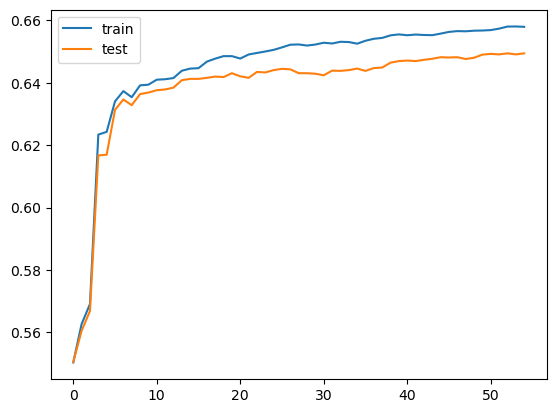

In [10]:
plt.plot(trainscore_np, label="train")
plt.plot(testscore, label='test')
plt.legend()
plt.show() # use the x-variable when test starts to drop off as n_estimators 2 cells above. Once it starts declining, we overfit the model.

## Basic EPS Expectations - 1-Year Forecast
- Will EPS go up or down from last year?
- to switch from Random Forest to Gradient Boosting model, uncomment "X_one" and change "model" to "model1"

In [14]:
firm_id = 5071 #gvkey of firm of choice

#NVDA - 117768
#UBER - 35077
#SOFI - 38916
#GIS - 5071
#MSFT 12141

firmdata = df[df["gvkey"] == firm_id].sort_values("fyear")

row = firmdata.iloc[-1]                    
X_one = row[predictor_columns].to_frame().T 
####X_one = X_one.fillna(X_train.mean())

# 0 = EPS down, 1 = EPS up
pred = model.predict(X_one)[0]
prob = model.predict_proba(X_one)[0,1]

print("Prediction:", pred)
print("Probability that EPS increases YoY:", prob)


Prediction: 0
Probability that EPS increases YoY: 0.16
